# Project Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

# Task 1: #
Find customers who are similar to a given customer. This will help the company's agents with marketing.


# Task 2: #
Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?


# Task 3: #
Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.


# Task 4: #
Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.


# Data Preprocessing & Exploration

`Initialization`

In [47]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pygwalker as pyg

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

from scipy.spatial import distance
from scipy.sparse import csc_matrix

from sklearn.model_selection import train_test_split

from IPython.display import display

`data import`

Loading data and conducting a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/Linear Algebra/insurance_us.csv')

display(df)

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [48]:
pyg.walk(df)

Box(children=(HTML(value='<div id="ifr-pyg-0" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

Renaming the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2919,0,22.0,56600.0,0,0
3418,1,19.0,59000.0,1,0
475,1,23.0,35500.0,2,0
4397,0,34.0,42200.0,0,0
596,1,29.0,40300.0,1,0
3184,1,52.0,44100.0,1,2
3928,0,36.0,38200.0,3,0
1166,0,35.0,31600.0,0,0
3399,1,33.0,38400.0,3,0
244,0,29.0,47000.0,5,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('string').str.split('.').str[0]
df['age'] = df['age'].apply(np.int64)

In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
df.describe().T
# Does everything look okay?

,count,mean,std,min,25%,50%,75%,max
gender,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
age,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
income,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
family_members,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
insurance_benefits,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


In [9]:
## individually:
## gender 0-1 looks ok
## age looks fine with the range of 18-65
## income follows the path of age (older/more money)
## family_members have a range of 0-6 which looks fine
## insurance_benefits also looks fine, 0 = no claims - 5 = 5 claims

## collectively:
## scaling differences in the values which needs to be taken into account (specially the magnitude of income)

In [10]:
## other:
## could convert last two columns into categorical column, 0-1 for 'siblings' and 0-1 for 'claim'

## EDA

Checking whether there are certain groups of customers by looking at the pair plot.

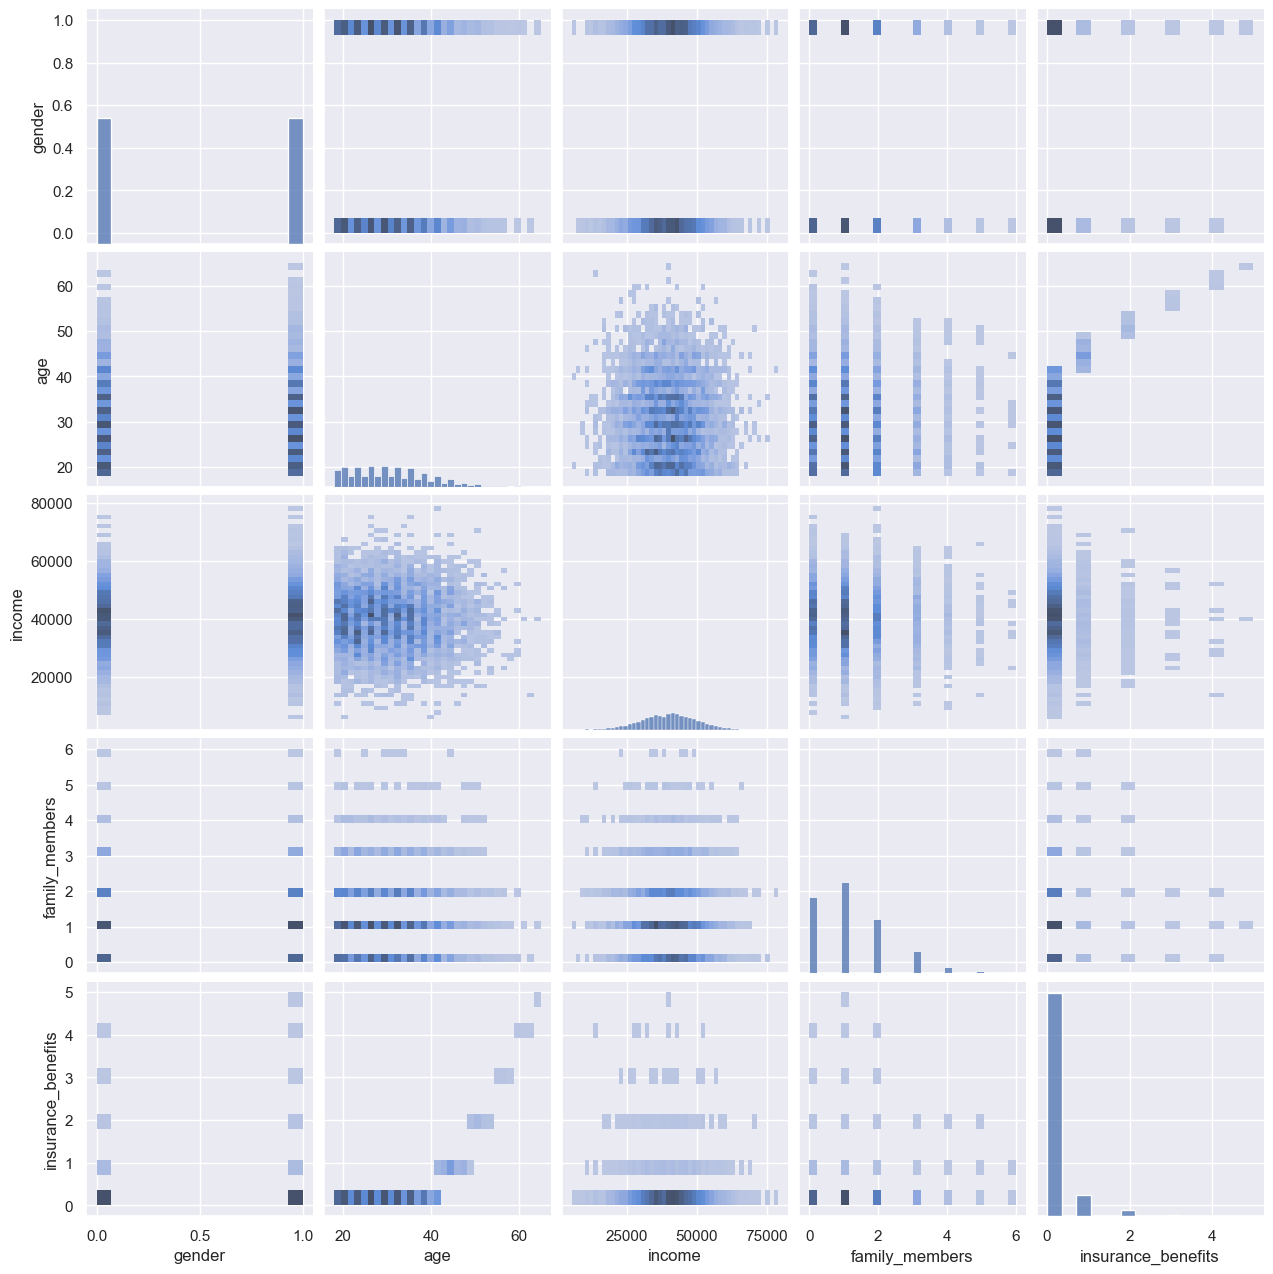

In [14]:
sns.set_theme()
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(13, 13)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

In [15]:
df.corr()

,gender,age,income,family_members,insurance_benefits
gender,1.000000,0.002074,0.014910,-0.008991,0.010140
age,0.002074,1.000000,-0.019093,-0.006692,0.651030
income,0.014910,-0.019093,1.000000,-0.030296,-0.014963
family_members,-0.008991,-0.006692,-0.030296,1.000000,-0.036290
insurance_benefits,0.010140,0.651030,-0.014963,-0.036290,1.000000


# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Questions to answer:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?

- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [17]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    nbrs = NearestNeighbors(metric=metric).fit(df)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

`data scaling`

In [18]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [19]:
df_scaled.sample(5)
df_scaled = df_scaled.drop('insurance_benefits', axis=1)

## df.iloc[1][feature_names]
#print(df_scaled)

In [20]:
df_not_scaled = df.copy()
df_not_scaled.loc[:, feature_names] = df[feature_names].to_numpy()
df_not_scaled = df_not_scaled.drop('insurance_benefits', axis=1)

Similar records for a given one for every combination

In [21]:
print('Scaled dataset - Euclidean Distance')
display(get_knn(df_scaled, 10, 100, 'euclidean'))

Scaled dataset - Euclidean Distance


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



,gender,age,income,family_members,distance
10,1,0.384615,0.463291,0.166667,0.000000
4377,1,0.384615,0.473418,0.166667,0.010127
1389,1,0.369231,0.464557,0.166667,0.015437
760,1,0.369231,0.462025,0.166667,0.015437
2254,1,0.400000,0.455696,0.166667,0.017157
...,...,...,...,...,...
3681,1,0.415385,0.520253,0.166667,0.064741
2359,1,0.353846,0.406329,0.166667,0.064741
2754,1,0.430769,0.417722,0.166667,0.064860
2104,1,0.323077,0.439241,0.166667,0.066071


In [22]:
print('No scaling dataset - Euclidean Distance')
display(get_knn(df_not_scaled, 10, 100, 'euclidean'))

No scaling dataset - Euclidean Distance


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



,gender,age,income,family_members,distance
10,1,25,36600.0,1,0.000000
4039,1,25,36600.0,2,1.000000
2037,1,26,36600.0,0,1.414214
3247,1,26,36600.0,2,1.414214
1508,0,26,36600.0,0,1.732051
...,...,...,...,...,...
426,0,23,36900.0,1,300.008333
3122,0,27,36300.0,0,300.010000
303,1,28,36900.0,1,300.015000
2020,0,22,36900.0,1,300.016666


In [23]:
print('Scaled dataset - Manhattan Distance')
display(get_knn(df_scaled, 10, 20, 'manhattan'))

Scaled dataset - Manhattan Distance


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



,gender,age,income,family_members,distance
10,1,0.384615,0.463291,0.166667,0.000000
4377,1,0.384615,0.473418,0.166667,0.010127
1389,1,0.369231,0.464557,0.166667,0.016650
760,1,0.369231,0.462025,0.166667,0.016650
2254,1,0.400000,0.455696,0.166667,0.022980
26,1,0.384615,0.437975,0.166667,0.025316
3261,1,0.400000,0.473418,0.166667,0.025511
4241,1,0.369231,0.446835,0.166667,0.031840
4201,1,0.400000,0.446835,0.166667,0.031840
4128,1,0.384615,0.430380,0.166667,0.032911


In [24]:
print('No scaling dataset - Manhattan Distance')
display(get_knn(df_not_scaled, 10, 20, 'manhattan'))

No scaling dataset - Manhattan Distance


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



,gender,age,income,family_members,distance
10,1,25,36600.0,1,0.0
4039,1,25,36600.0,2,1.0
3247,1,26,36600.0,2,2.0
2037,1,26,36600.0,0,2.0
1949,0,24,36600.0,0,3.0
1508,0,26,36600.0,0,3.0
49,0,28,36600.0,1,4.0
2890,0,23,36600.0,0,4.0
1573,0,27,36600.0,2,4.0
4797,1,29,36600.0,2,5.0


`Answers to the questions`

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

It does affects the output. For non-scaled data, the distance values are much too 'spread out' by the magnitude differentials from both the age and income column (especially telling once expanding k to +100 and seeing a larget set of the table). We also see different neighboring customers due to the data not being scaled and/or the features not being representative to each other.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Comparing the two tables which leverage the Manhattan distance, we see some similarity in the distance observations. But the list of neighbors differs between the two. For example, where data is scaled we see the higher frequency of `gender=1` closest to our `n object` which is `10` compared to the non-scaled evaluation. This type of difference becomes much wider as `k` is increased.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [25]:
# calculate the target

df['insurance_benefits_received'] = df['insurance_benefits'] > 0
#print(df['insurance_benefits_received'])

insurance_benefits = df['insurance_benefits_received'].values
#print(insurance_benefits)

insurance_benefits_all = df.query("insurance_benefits_received > 0").values
#print(insurance_benefits_all)

<Axes: title={'center': 'count (target)'}, xlabel='insurance_benefits_received'>

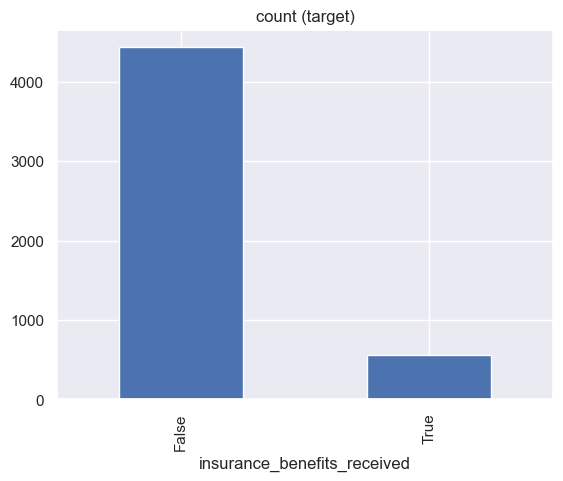

In [26]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts().plot(kind='bar', title='count (target)')

In [27]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [28]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [29]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(insurance_benefits), seed=42)  
    
    eval_classifier(insurance_benefits, y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [30]:
# orig. data

y_orig = df['insurance_benefits'].to_numpy()
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits_received'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=12345)

for n in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    prediction_test = knn.predict(X_test)
    eval_classifier(y_test, prediction_test)
    print('')

F1: 0.61
Confusion Matrix
[[0.87133333 0.02      ]
 [0.05266667 0.056     ]]

F1: 0.41
Confusion Matrix
[[0.88733333 0.004     ]
 [0.08       0.02866667]]

F1: 0.41
Confusion Matrix
[[0.87933333 0.012     ]
 [0.078      0.03066667]]

F1: 0.28
Confusion Matrix
[[0.88866667 0.00266667]
 [0.09066667 0.018     ]]

F1: 0.27
Confusion Matrix
[[0.88533333 0.006     ]
 [0.09066667 0.018     ]]

F1: 0.11
Confusion Matrix
[[0.89       0.00133333]
 [0.102      0.00666667]]

F1: 0.11
Confusion Matrix
[[0.88866667 0.00266667]
 [0.102      0.00666667]]

F1: 0.07
Confusion Matrix
[[0.89133333 0.        ]
 [0.10466667 0.004     ]]

F1: 0.08
Confusion Matrix
[[0.89133333 0.        ]
 [0.104      0.00466667]]

F1: 0.00
Confusion Matrix
[[0.89133333 0.        ]
 [0.10866667 0.        ]]



In [31]:
# scaled data (df_scaled)

features_train, features_test, target_train, target_test = train_test_split(X,
                                                                            y, 
                                                                            test_size=0.3, 
                                                                            random_state=12345)
scaler = MaxAbsScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

for n in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(features_train, target_train)
    prediction_test = knn.predict(features_test)
    eval_classifier(target_test, prediction_test)
    print('')

F1: 0.97
Confusion Matrix
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]

F1: 0.93
Confusion Matrix
[[8.90666667e-01 6.66666667e-04]
 [1.40000000e-02 9.46666667e-02]]

F1: 0.95
Confusion Matrix
[[0.88933333 0.002     ]
 [0.00866667 0.1       ]]

F1: 0.91
Confusion Matrix
[[0.88933333 0.002     ]
 [0.01666667 0.092     ]]



F1: 0.92
Confusion Matrix
[[0.88666667 0.00466667]
 [0.01133333 0.09733333]]

F1: 0.90
Confusion Matrix
[[0.89       0.00133333]
 [0.018      0.09066667]]

F1: 0.92
Confusion Matrix
[[0.88733333 0.004     ]
 [0.01266667 0.096     ]]

F1: 0.90
Confusion Matrix
[[0.88866667 0.00266667]
 [0.01733333 0.09133333]]

F1: 0.92
Confusion Matrix
[[0.88866667 0.00266667]
 [0.01466667 0.094     ]]

F1: 0.88
Confusion Matrix
[[0.88866667 0.00266667]
 [0.02133333 0.08733333]]



**Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference.**


Scaling makes a big difference here. For scaled data and as K increases, F1 slightly diminishes but starts at a much higher point overall compared to the non-scaled/original dataset (where F1 starts at .61 and quickly goes to zero). Scaled data is overall consistenly higher for all `k` iterations.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [32]:
import math

class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [33]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

`base data`

In [34]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print('lr weights:', lr.weights)
print('')
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

lr weights: [-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]

RMSE: 0.34
R2: 0.66


`Scaled Data - MaxAbsScaler()`

In [35]:
scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = train_test_split(df_scaled, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(scaled_X_train, scaled_y_train)
print('lr weights:', lr.weights)
print('')
scaled_y_test_pred = lr.predict(scaled_X_test)
eval_regressor(scaled_y_test, scaled_y_test_pred)

lr weights: [-0.94353901  0.01642727  2.32372069 -0.02059875 -0.07014128]

RMSE: 0.34
R2: 0.66


***Can you see any difference in RMSE between these two cases?***

From our observations, the RMSE values don't differ, even if weights are different. Scaling may make a difference for linear regression if we apply L1/L2 regularization or train the model using stochastic gradient descent.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [36]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]
#display(df_pn)

In [37]:
X = df_pn.to_numpy()
print(X)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]


Generating a random matrix $P$.

In [38]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [39]:
print('X @ P - Transformed Matrix\n')
transformation = X @ P
print(transformation)

#print(X @ P.T)
#print(P @ X.T)
#print(P @ P) 
print('')
print('P Inverse\n')
P_inverse = np.linalg.inv(P)
print(P)
print('')
# print('P_inverse\n')
# print(P_inverse)
# print('')
# print('P.dot(P_inverse)\n')
# print(P.dot(P_inverse))
# print('')
# print('P_inverse.dot(P)\n')
# print(P_inverse.dot(P))
# invertible

# print('')
# print('P.T.dot(X.T) - Similar valus to `X @ P`\n')
# print(P.T.dot(X.T)) # backing into the transformation values

X @ P - Transformed Matrix

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

P Inverse

[[0.77395605 0.43887844 0.85859792 0.69736803]
 [0.09417735 0.97562235 0.7611397  0.78606431]
 [0.12811363 0.45038594 0.37079802 0.92676499]
 [0.64386512 0.82276161 0.4434142  0.22723872]]



**Can you guess the customers' ages or income after the transformation?**

One cannot guess the customer's age or income, you can however, see some directional movement with those two columns which follows the path/format of the original dataset (behaving similarly to the original data).

In [40]:
display(df_pn)
display(pd.DataFrame(transformation, columns=personal_info_column_list))

,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0
...,...,...,...,...
4995,0,28,35700.0,2
4996,0,34,52400.0,1
4997,0,20,33900.0,2
4998,1,22,32700.0,3


,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378
...,...,...,...,...
4995,4577.581382,16107.740932,13259.688205,33107.974380
4996,6717.000247,23634.217067,19456.138634,48589.438841
4997,4346.223425,15289.241265,12586.162644,31433.508886
4998,4194.093242,14751.991024,12144.029306,30323.887634


**Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.**

Making the assumption this data recovery is achieved through multiplying the transformed data by the inverse of P.

In [41]:
# 𝑋′ is the transpose matrix

# print('Original\n')
# print(X)
# print('')
# print('Transformed\n')
# print(transformation)
# print('')
print('Recovered\n')
recovered = transformation.dot(P_inverse)
print(recovered)
print('')

Recovered

[[1.00000000e+00 4.10000000e+01 4.96000000e+04 1.00000000e+00]
 [1.64503537e-12 4.60000000e+01 3.80000000e+04 1.00000000e+00]
 [9.25561194e-13 2.90000000e+01 2.10000000e+04 1.41940791e-12]
 ...
 [3.87221815e-12 2.00000000e+01 3.39000000e+04 2.00000000e+00]
 [1.00000000e+00 2.20000000e+01 3.27000000e+04 3.00000000e+00]
 [1.00000000e+00 2.80000000e+01 4.06000000e+04 1.00000000e+00]]



Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [42]:
print('The original data:')
display(pd.DataFrame(X, columns=personal_info_column_list).head(3))
print('')
print('The transformed one:')
display(pd.DataFrame(transformation, columns=personal_info_column_list).head(3))
print('')
print('The reversed (recovered) one:')
display(pd.DataFrame(recovered, columns=personal_info_column_list).head(3))
print('')

The original data:


,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0



The transformed one:


,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631



The reversed (recovered) one:


,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,1.645035e-12,46.0,38000.0,1.000000e+00
2,9.255612e-13,29.0,21000.0,1.419408e-12


**You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?**

Would assume it is due to the overall process of obfuscatiing of the data, like the application of float numbers during transformation (from int).

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

***How would  𝑤 and  𝑤𝑃 be linked if you simplify the formula for  𝑤𝑃 above?***

- Based off of the condensed/manipulated result:
<tr>
<td></td><td>$w_P = P^{-1}\cdot w$</td><td></td>
</tr>


***What would be predicted values with 𝑤𝑃?***

- Same as the values before the obsfucation. We can get back to the original formula using the multiplicative identity property:

<table>
<tr>
<td>replacing 𝑤 with 𝑤𝑃</td><td>$\hat{y_P} = X_{val}P \cdot w_P$</td>
</tr>
<tr>
<td>Multiplicative identity</td><td>$\hat{y_P} = X_{val}P \cdot P^{-1}w$</td>
</tr>
<tr>
<td>Multiplicative identity</td><td>$\hat{y_P} = X_{val} P \cdot I \cdot w$</td>
</tr>
<tr>
<td>Multiplicative identity</td><td>$\hat{y_P} = X_{val}w$</td>
</tr>
<tr>
<td></td><td>$\hat{y_P} = \hat{y}$</td>
</tr>
</table>

***What does that mean for the quality of linear regression if you measure it with RMSE?***

- RMSE is not expected to change given equality.

**Analytical proof**

1. Formula is condesed as things get removed or cancelled out (one by one; manupulation)
2. Masking does not affect linear regression itself


<table>
<tr>
<td></td><td>$w_P = [(XP)^T XP]^{-1} (XP)^T y$</td>
</tr>
<tr>
<td>Reversivity</td><td>$w_P = [(P^TX^T XP]^{-1} P^TX^T y$</td>
</tr>
<tr>
<td>Associative property</td><td>$w_P = [(P^T(X^TX)P]^{-1} P^TX^T y$</td>
</tr>
<tr>
<td>Multiplicative identity</td><td>$w_P = P^{-1}(X^TX)^{-1}(P^{-1}) P^TX^T y$</td>
</tr>
<tr>
<td>Associative property</td><td>$w_P = P^{-1}(X^TX)^{-1}[(P^{-1}) P^T]X^T y$</td>
</tr>
<tr>
<td>Multiplicative identity</td><td>$w_P = P^{-1}(X^TX)^{-1}I \cdot X^T y$</td>
</tr>
<tr>
<td></td><td>$w_P = P^{-1}(X^TX)^{-1}X^T y$</td>
</tr>
<tr>
<td></td><td>$w_P = P^{-1}\cdot w$</td><td></td>
</tr>
</table>

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [43]:
# original data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test) # metrics were similar leveraging the training dataset
eval_regressor(y_test, y_test_pred) # metrics were similar leveraging the training dataset

RMSE: 0.34
R2: 0.66


In [44]:
# obfuscation transformation

X_train, X_test, y_train, y_test = train_test_split(transformation, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test) # metrics were similar leveraging the training dataset
eval_regressor(y_test, y_test_pred) # metrics were similar leveraging the training dataset

RMSE: 0.34
R2: 0.66


# Conclusions

`Scaling and imbalancing - output improvement after normalizing/standardizing across features`
    
- Through the analysis, we see how data which isn't scaled can affect the output for distance values. As features 
feature larger variability or magnitude the distance output itself becomes more and more spread out (more easily seen when we expand `k` above `100`). We may also see these differences by utilizing the same distance method across scaled and non-scaled data for it to tell us what are the actual variations in output and how deep the variability truly is.

    
- Scaling makes a big difference when it comes to scores. For scaled data and as K increases, we see downturn shifts with F1 score (higher starting point overall compared to the non-scaled/original dataset). Under our non-scaled data, F1 score starts at .61 and quickly goes to zero at the 10th iteration of `k` while scaled data is overall consistent for the same value of`k` iterations (hovers right around the .90 mark with 10 iterations).

    
`Data obfuscating - proving that obsfucating our data can work with LR models without affecting certain outputs`
    
- While going through the process of transformation, we concluded that there is enough proof (both qualitative and quantiative proof) that data masking does not affect our RMSE metrics (*under this specific modeling scenario with these specific parameters*). With that said, if our transformation matrix is known there's a likely chance that our original data may be 'backed into' or 'recovered' but to a certain degree (will never be able to fully guess the original dataset). 


# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>